In [ ]:
import torch, torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import  transforms


import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.optim as optim
import tqdm
import os
from torch.utils.data import DataLoader
%matplotlib inline
from torchsummary import summary
import seaborn as sns
sns.set()

import seaborn as sns

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs=30
BATCH_SIZE=256
SHUFFLE_DATASET =True
NUM_DATALOADER_WORKERS = 1


data_root='.'

class Rescale(object):
    def __call__(self,image):
        image = image-image.min()
        image = image/image.max()
        return image


In [ ]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

train_loader = torch.utils.data.DataLoader(
            dataset= torchvision.datasets.MNIST(
                root = data_root,
                train=True,
                transform=mnist_transformations,
                download = True
                ),
            batch_size=BATCH_SIZE,
            shuffle = SHUFFLE_DATASET,
            num_workers =NUM_DATALOADER_WORKERS
)

test_loader = torch.utils.data.DataLoader(
            dataset= torchvision.datasets.MNIST(
                root = data_root,
                train=False,
                transform=mnist_transformations,
                ),
            batch_size=BATCH_SIZE,
            shuffle = False,
            num_workers =NUM_DATALOADER_WORKERS)

In [ ]:
# Розглядаємо реалізацію, Автоенкодера лише з лінійними шарами
class AutoencoderLinear(nn.Module):
    def __init__(self):
        super(AutoencoderLinear, self).__init__()
    
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(in_features=64, out_features=32),
            )
     
        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            nn.LeakyReLU(0.01) ,
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=784),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Реалізація Автоенкодера із згортковими шарами
class AutoencoderCnn(nn.Module):
    def __init__(self):
        super(AutoencoderCnn, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ELU(),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ELU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




In [ ]:
autoencoder_cnn = AutoencoderCnn()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_cnn.parameters(), lr=1e-5)
train_loss_cnn = []
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for data in train_loader:

        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = autoencoder_cnn(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    loss = running_loss / len(train_loader)        
    train_loss_cnn.append(loss)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss))

Epoch [1/30], Loss: 0.1778
Epoch [2/30], Loss: 0.1696
Epoch [3/30], Loss: 0.1612
Epoch [4/30], Loss: 0.1523
Epoch [5/30], Loss: 0.1429
Epoch [6/30], Loss: 0.1328
Epoch [7/30], Loss: 0.1222
Epoch [8/30], Loss: 0.1111
Epoch [9/30], Loss: 0.0998
Epoch [10/30], Loss: 0.0887
Epoch [11/30], Loss: 0.0780
Epoch [12/30], Loss: 0.0682
Epoch [13/30], Loss: 0.0594
Epoch [14/30], Loss: 0.0518
Epoch [15/30], Loss: 0.0453
Epoch [16/30], Loss: 0.0400
Epoch [17/30], Loss: 0.0356
Epoch [18/30], Loss: 0.0320
Epoch [19/30], Loss: 0.0290
Epoch [20/30], Loss: 0.0266
Epoch [21/30], Loss: 0.0245
Epoch [22/30], Loss: 0.0228
Epoch [23/30], Loss: 0.0213
Epoch [24/30], Loss: 0.0200
Epoch [25/30], Loss: 0.0189
Epoch [26/30], Loss: 0.0179
Epoch [27/30], Loss: 0.0170
Epoch [28/30], Loss: 0.0162
Epoch [29/30], Loss: 0.0155
Epoch [30/30], Loss: 0.0149


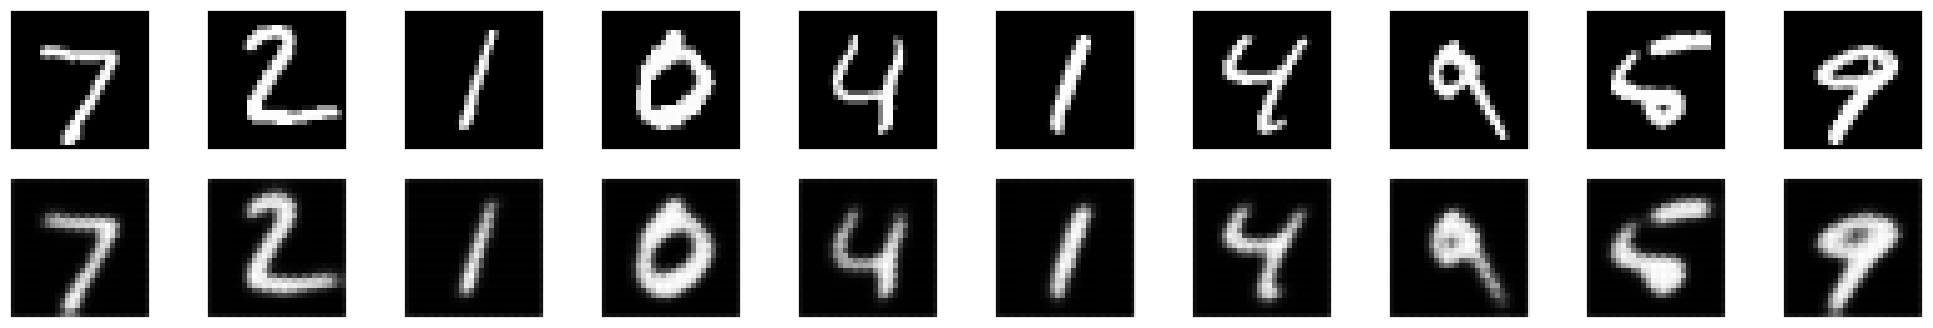

In [ ]:

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = autoencoder_cnn(images)

images = images.numpy()

output = output.view(BATCH_SIZE, 1, 28, 28)

output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
autoencoder_l = AutoencoderLinear()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_l.parameters(), lr=1e-5)

In [ ]:
train_loss = []
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = autoencoder_l(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss = running_loss / len(train_loader)         
    train_loss.append(loss)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss))

Epoch [1/30], Loss: 0.2243
Epoch [2/30], Loss: 0.1902
Epoch [3/30], Loss: 0.1344
Epoch [4/30], Loss: 0.0917
Epoch [5/30], Loss: 0.0733
Epoch [6/30], Loss: 0.0659
Epoch [7/30], Loss: 0.0623
Epoch [8/30], Loss: 0.0599
Epoch [9/30], Loss: 0.0581
Epoch [10/30], Loss: 0.0566
Epoch [11/30], Loss: 0.0554
Epoch [12/30], Loss: 0.0542
Epoch [13/30], Loss: 0.0532
Epoch [14/30], Loss: 0.0523
Epoch [15/30], Loss: 0.0513
Epoch [16/30], Loss: 0.0505
Epoch [17/30], Loss: 0.0497
Epoch [18/30], Loss: 0.0489
Epoch [19/30], Loss: 0.0482
Epoch [20/30], Loss: 0.0476
Epoch [21/30], Loss: 0.0469
Epoch [22/30], Loss: 0.0463
Epoch [23/30], Loss: 0.0457
Epoch [24/30], Loss: 0.0452
Epoch [25/30], Loss: 0.0446
Epoch [26/30], Loss: 0.0440
Epoch [27/30], Loss: 0.0434
Epoch [28/30], Loss: 0.0428
Epoch [29/30], Loss: 0.0422
Epoch [30/30], Loss: 0.0416


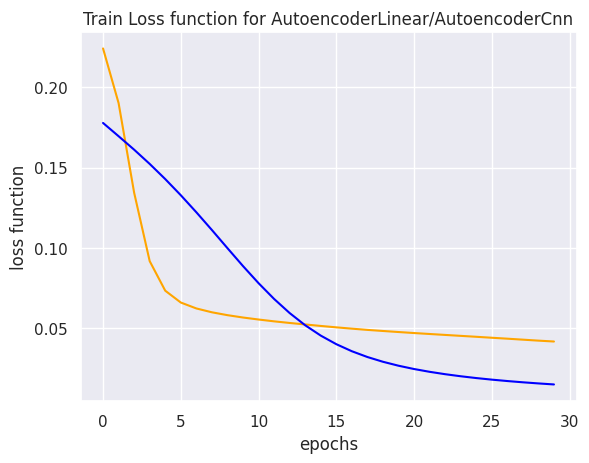

In [ ]:
plt.figure()
sns.lineplot(train_loss,color='orange')
sns.lineplot(train_loss_cnn,color='blue')
plt.title('Train Loss function for AutoencoderLinear/AutoencoderCnn')
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.show()

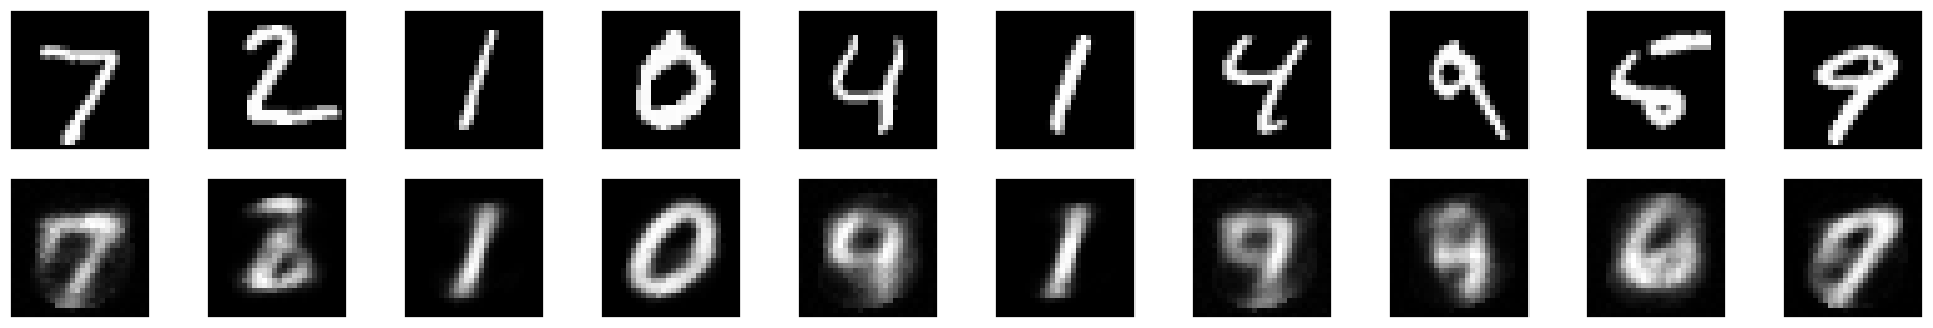

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

image = images.view(images.size(0), -1)
outputs = autoencoder_l(image)

image = image.numpy()

output = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)